In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sns  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
cd Data/

/Users/asadmolayari/Desktop/my_courses/pytorch/Data


In [2]:
transform =transforms.ToTensor()

In [ ]:
train_data = datasets.CIFAR10(root='/Users/asadmolayari/Desktop/my_courses/pytorch/Data', train=True,download=True,
                             transform=transform)
test_data = datasets.CIFAR10(root='/Users/asadmolayari/Desktop/my_courses/pytorch/Data', train=False,download=True,
                             transform=transform)

In [10]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/asadmolayari/Desktop/my_courses/pytorch/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /Users/asadmolayari/Desktop/my_courses/pytorch/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [12]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [20]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [13]:
for images, labels in train_loader:
    break

labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

print(labels.numpy())
print(*np.array([class_names[i] for i in labels]))
im = make_grid(images, nrow=5)
plt.figure(figsize=(10,5))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

## Define the model
In the previous section we used two convolutional layers and two pooling layers before feeding data through a fully connected hidden layer to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC. We'll use the same format here.

The only changes are:
* take in 3-channel images instead of 1-channel
* adjust the size of the fully connected input<br>

Our first convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in as <tt>nn.Conv2d(3,6,3,1)</tt>

In [24]:
class Conv_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(6*6*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [25]:
torch.manual_seed(101)
model = Conv_Net()
model

Conv_Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.72993660  accuracy:  26.820%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.45265830  accuracy:  32.535%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.75124586  accuracy:  35.993%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.66407084  accuracy:  38.398%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 2.20951843  accuracy:  40.248%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.42143297  accuracy:  49.700%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.73744464  accuracy:  50.645%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.88247365  accuracy:  50.743%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.09317040  accuracy:  51.265%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.64743924  accuracy:  51.834%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.67615598  accuracy:  55.700%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.12799299  accuracy:  55.765%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.46636271  accuracy:  55.993%
epoch:  2  b

## Plot the loss and accuracy comparisons

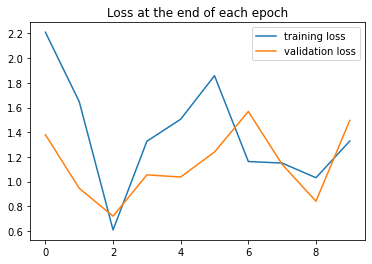

In [30]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

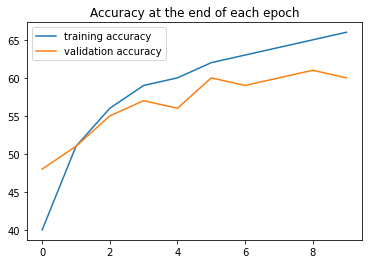

In [31]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [17]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4940), tensor(5519), tensor(5685), tensor(5812), tensor(5930), tensor(6048), tensor(5941), tensor(6166), tensor(6035), tensor(6105)]

Test accuracy: 61.050%


## Display the confusion matrix
In order to map predictions against ground truth, we need to run the entire test set through the model.<br>
Also, since our model was not as accurate as with MNIST, we'll use a <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>heatmap</a> to better display the results.

In [40]:
predicted.view(-1)

tensor([3, 8, 8,  ..., 5, 6, 7])

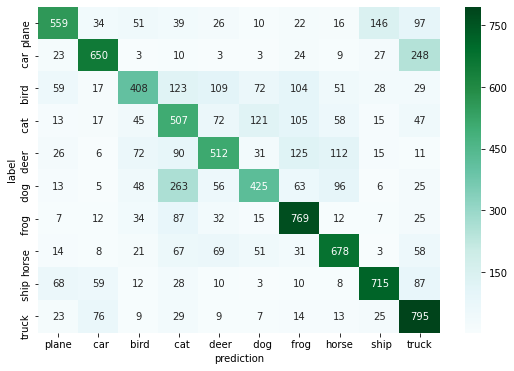

In [43]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]

arr = confusion_matrix(y_test, predicted)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label")
plt.show();